In [1]:
import pandas as pd

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

In [2]:
metabolomics_data = pd.read_csv("../../MCF7_removal/Metabolomics_data_noMCF7.csv")
metabolomics_data = metabolomics_data.set_index("ionIdx")
metabolomics_data = metabolomics_data.drop("ionMz", axis =1)

In [3]:
celllines_mutations = pd.read_csv("../../../GEMICCL/Mutation.csv", sep = "\t")
celllines_mapped = pd.read_csv("../../MCF7_removal/Celllines_mapping_manual_noMCF7.csv")

# Get only cell lines with ID
celllines_mapped = celllines_mapped.drop_duplicates(subset = ["dsIdx"])
celllines_mapped = celllines_mapped.dropna(subset = ["ID"])
sample_data_tissue = celllines_mapped["DI"].tolist()

<ipython-input-3-230e178013df>:1: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  celllines_mutations = pd.read_csv("../../../GEMICCL/Mutation.csv", sep = "\t")


In [4]:
celllines_list = celllines_mapped["ID"].unique().tolist()
celllines_notinmutationset = set(celllines_list) - set(celllines_mutations['CellLineName_Cellosaurus'])
celllines_mapped_mutations = celllines_mapped[~celllines_mapped["ID"].isin(celllines_notinmutationset)]

In [14]:
celllines_withmutations = celllines_mutations[celllines_mutations["CellLineName_Cellosaurus"].isin(celllines_list)]
celllines_withmutations.to_csv("./Mutations_in_celllines.csv")

In [6]:
def querygenemetabolite(gene, metabolite, label = "2-hydroxyglutarate"):
    # Get celline ids with a mutation (non silent)
    gene_of_interest = celllines_mutations[celllines_mutations["HGNC"] == gene]
    gene_of_interest = gene_of_interest[gene_of_interest["MutationType"] != "Silent"]
    gene_of_interest = gene_of_interest[gene_of_interest["MutationType"].notna()]
    gene_of_interest_celllines = set(gene_of_interest["CellLineName_Cellosaurus"])
    
    ## Get the cell lines with mutations
    cellines_with_mutation = celllines_mapped_mutations[celllines_mapped_mutations["ID"].isin(gene_of_interest_celllines)]["dsIdx"].tolist()
    cellines_without_mutation = celllines_mapped_mutations[~celllines_mapped_mutations["ID"].isin(gene_of_interest_celllines)]["dsIdx"].tolist()
    cellines_with_mutation = [str(x) for x in cellines_with_mutation]
    cellines_without_mutation = [str(x) for x in cellines_without_mutation]
    
    mutationdict = dict(zip(gene_of_interest["CellLineName_Cellosaurus"],gene_of_interest["AA_Mutation"]))
    celllines_mutated = celllines_mapped_mutations[celllines_mapped_mutations["ID"].isin(gene_of_interest_celllines)]
    mutation_aa = celllines_mutated["ID"].map(mutationdict)
    
    ## Get the metabolomics data
    mutated_celllines = metabolomics_data[cellines_with_mutation].transpose()
    nonmutated_celllines = metabolomics_data[cellines_without_mutation].transpose()
    
    mutated_celllines["Mutation"] = 1
    mutated_celllines["MutationAA"] = mutation_aa.values
    nonmutated_celllines["Mutation"] = 0
    nonmutated_celllines["MutationAA"] = "WT"
    
    celllines_labeled = pd.concat([mutated_celllines, nonmutated_celllines])
    celllines_labeled.index = celllines_labeled.index.map(str)
    
    celllines_mapped_mutations[celllines_mapped_mutations["ID"].isin(gene_of_interest_celllines)]["ID"].unique()
    
    gene_ranked = celllines_labeled.sort_values(by =metabolite).reset_index()
    gene_ranked["index"] = gene_ranked.index
    mutationonly = gene_ranked[gene_ranked["Mutation"] == 1]
    nomutation = gene_ranked[gene_ranked["Mutation"] == 0]
    
    matplotlib.rcParams['figure.figsize'] = [8, 10]
    palette = sns.color_palette("Set3", 10)[3:]
    g1 = sns.swarmplot(y= np.log10(nomutation[metabolite]), color = "grey", zorder =1)
    g = sns.swarmplot(y= np.log10(mutationonly[metabolite]), size = 10, hue = mutationonly["MutationAA"],
                  palette = palette, edgecolor = "k", linewidth= 2, zorder = 3, x=[""]*len(mutationonly))

    sns.despine()

    g.set_ylabel("Levels log$_{10}$", size = 20)
    #g.set_yticks([4, 4.5,5,5.5])
    g.set_yticklabels(g.get_yticks(), size = 20)
    g.yaxis.set_major_formatter(FormatStrFormatter('%g'))

    g.set_xlabel(label, size = 20)
    g.set_title(gene, size = 22)
    g.legend(prop={"size":15}, frameon = False, markerscale = 1.5)
    savename = gene + "_" + label + "_mutations.png"
    plt.savefig(savename, dpi = 400)

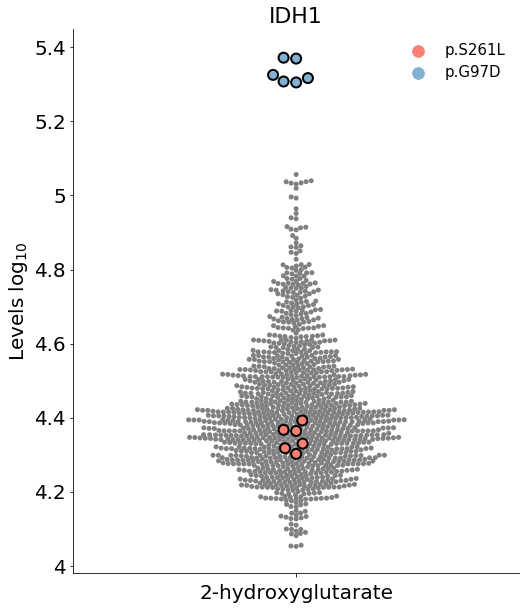

In [7]:
querygenemetabolite("IDH1", 118)

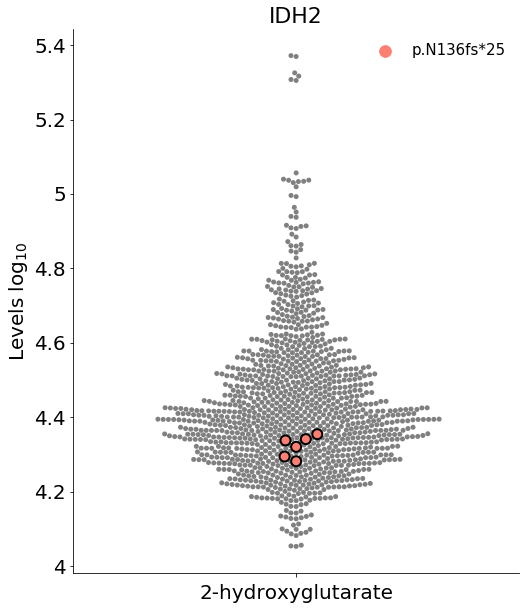

In [8]:
querygenemetabolite("IDH2", 118)

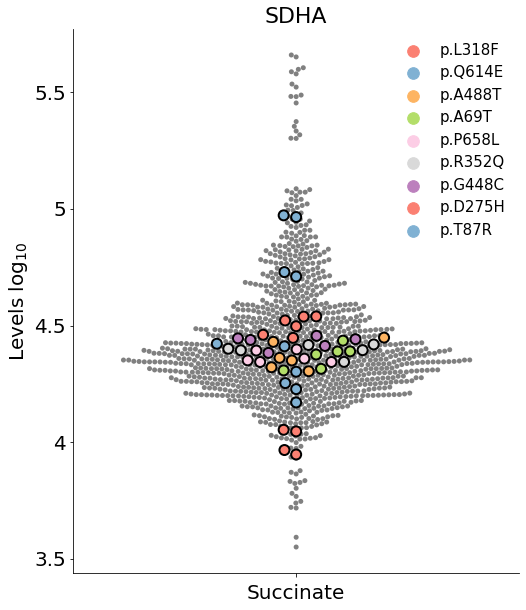

In [9]:
querygenemetabolite("SDHA", 65, "Succinate")

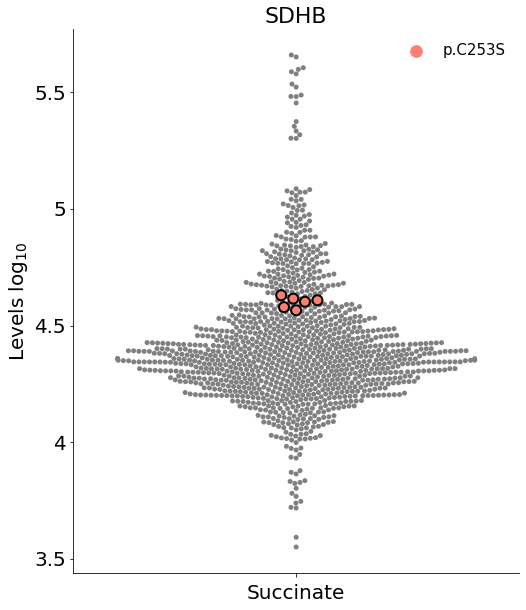

In [10]:
querygenemetabolite("SDHB", 65, "Succinate")

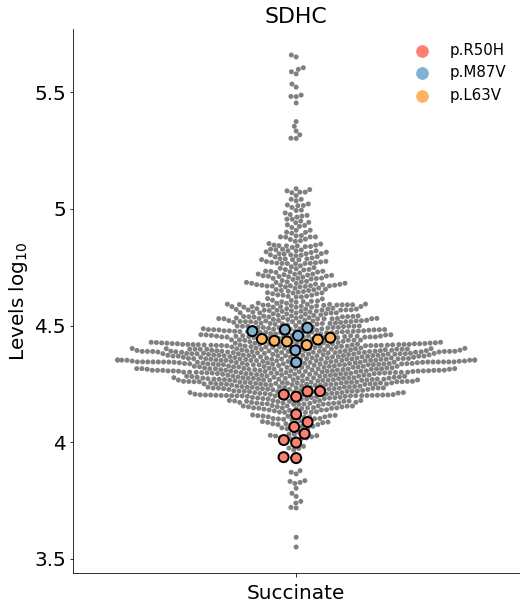

In [11]:
querygenemetabolite("SDHC", 65, "Succinate")

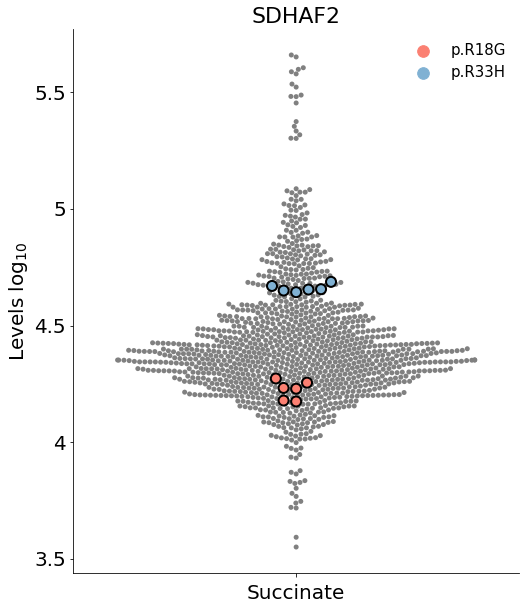

In [12]:
querygenemetabolite("SDHAF2", 65, "Succinate")

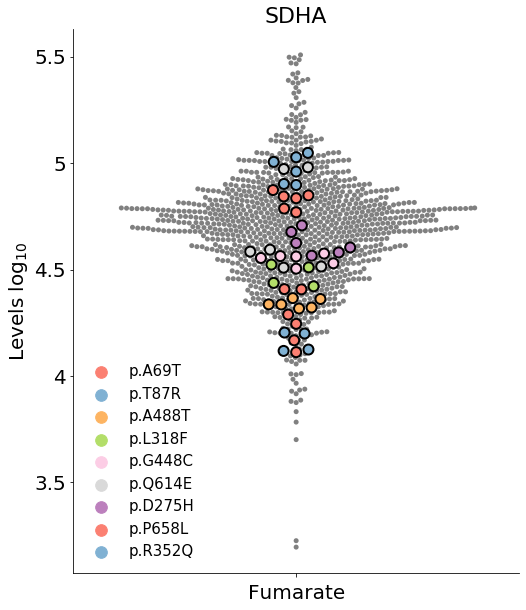

In [13]:
querygenemetabolite("SDHA", 59, "Fumarate")

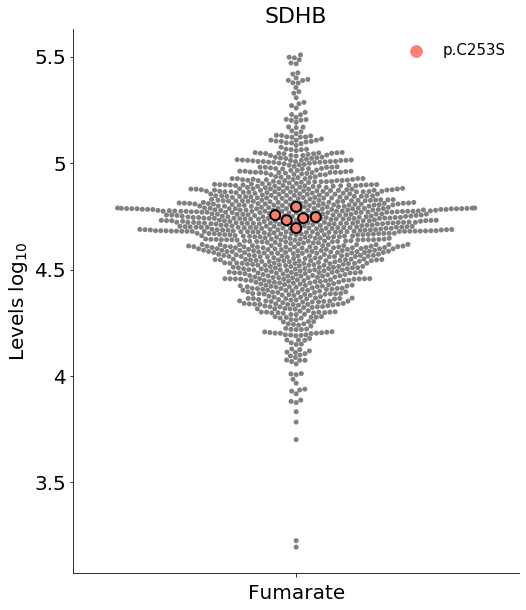

In [14]:
querygenemetabolite("SDHB", 59, "Fumarate")

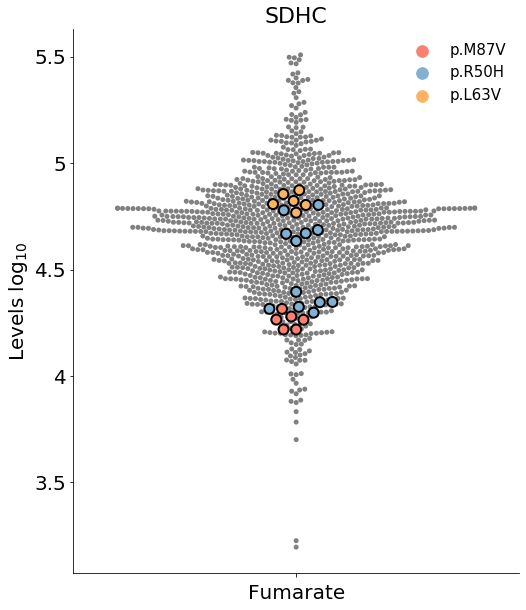

In [15]:
querygenemetabolite("SDHC", 59, "Fumarate")

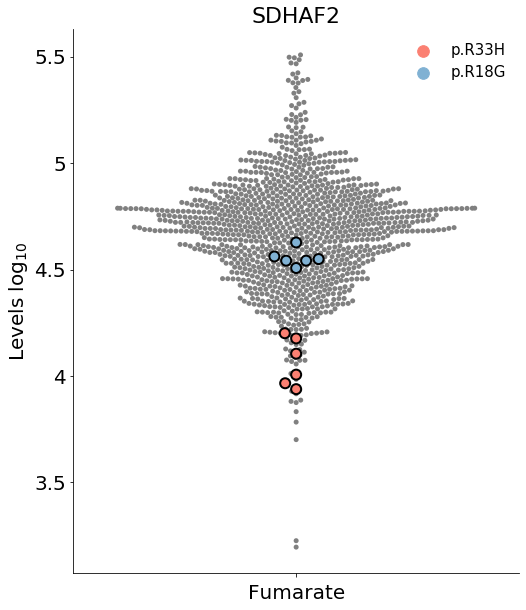

In [16]:
querygenemetabolite("SDHAF2", 59, "Fumarate")

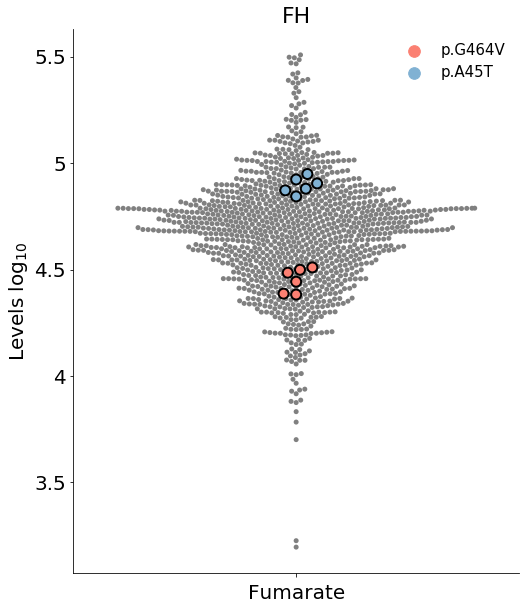

In [17]:
querygenemetabolite("FH", 59, "Fumarate")

In [18]:
def querygenesfratio(gene, label = "Succinate:Fumarate Ratio"):
    # Get celline ids with a mutation (non silent)
    gene_of_interest = celllines_mutations[celllines_mutations["HGNC"] == gene]
    gene_of_interest = gene_of_interest[gene_of_interest["MutationType"] != "Silent"]
    gene_of_interest = gene_of_interest[gene_of_interest["MutationType"].notna()]
    gene_of_interest_celllines = set(gene_of_interest["CellLineName_Cellosaurus"])
    
    ## Get the cell lines with mutations
    cellines_with_mutation = celllines_mapped_mutations[celllines_mapped_mutations["ID"].isin(gene_of_interest_celllines)]["dsIdx"].tolist()
    cellines_without_mutation = celllines_mapped_mutations[~celllines_mapped_mutations["ID"].isin(gene_of_interest_celllines)]["dsIdx"].tolist()
    cellines_with_mutation = [str(x) for x in cellines_with_mutation]
    cellines_without_mutation = [str(x) for x in cellines_without_mutation]
    
    mutationdict = dict(zip(gene_of_interest["CellLineName_Cellosaurus"],gene_of_interest["AA_Mutation"]))
    celllines_mutated = celllines_mapped_mutations[celllines_mapped_mutations["ID"].isin(gene_of_interest_celllines)]
    mutation_aa = celllines_mutated["ID"].map(mutationdict)
    
    ## Get the metabolomics data
    mutated_celllines = metabolomics_data[cellines_with_mutation].transpose()
    nonmutated_celllines = metabolomics_data[cellines_without_mutation].transpose()
    
    mutated_celllines["Mutation"] = 1
    mutated_celllines["MutationAA"] = mutation_aa.values
    nonmutated_celllines["Mutation"] = 0
    nonmutated_celllines["MutationAA"] = "WT"
    
    celllines_labeled = pd.concat([mutated_celllines, nonmutated_celllines])
    celllines_labeled.index = celllines_labeled.index.map(str)
    
    celllines_mapped_mutations[celllines_mapped_mutations["ID"].isin(gene_of_interest_celllines)]["ID"].unique()
    celllines_labeled["S_F_ratio"] = celllines_labeled[65]/celllines_labeled[59]
    gene_ranked = celllines_labeled.sort_values(by ="S_F_ratio").reset_index()
    querygenesfratio.celllines_labeled = celllines_labeled
    gene_ranked["index"] = gene_ranked.index
    mutationonly = gene_ranked[gene_ranked["Mutation"] == 1]
    nomutation = gene_ranked[gene_ranked["Mutation"] == 0]
    
    matplotlib.rcParams['figure.figsize'] = [8, 10]
    palette = sns.color_palette("Set3", 10)
    g1 = sns.swarmplot(y= np.log10(nomutation["S_F_ratio"]), color = "grey", zorder =1)
    g = sns.swarmplot(y= np.log10(mutationonly["S_F_ratio"]), size = 10, hue = mutationonly["MutationAA"],
                  palette = palette, edgecolor = "k", linewidth= 2, zorder = 3, x=[""]*len(mutationonly))

    sns.despine()

    g.set_ylabel("log$_{10}$ ratio", size = 20)
    #g.set_yticks([4, 4.5,5,5.5])
    g.set_yticklabels(g.get_yticks(), size = 20)
    g.yaxis.set_major_formatter(FormatStrFormatter('%g'))

    g.set_xlabel(label, size = 20)
    g.set_title(gene, size = 22)
    g.legend(prop={"size":15}, frameon = False, markerscale = 1.5)
    savename = gene + "_succinate_fumartate_ratio_mutations.png"
    plt.savefig(savename, dpi = 400)

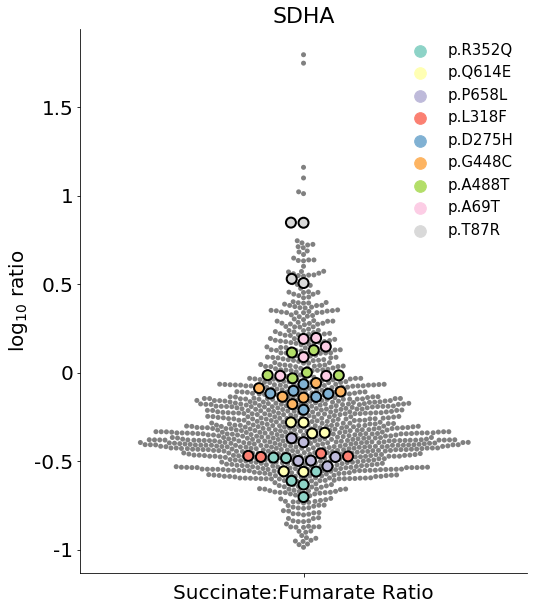

In [19]:
querygenesfratio("SDHA")

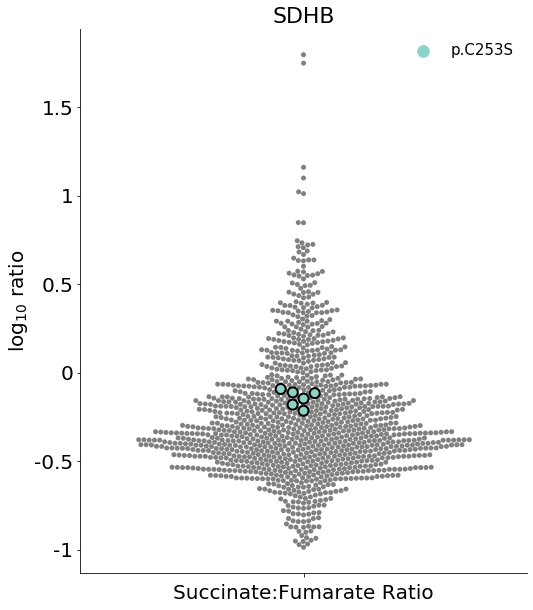

In [20]:
querygenesfratio("SDHB")

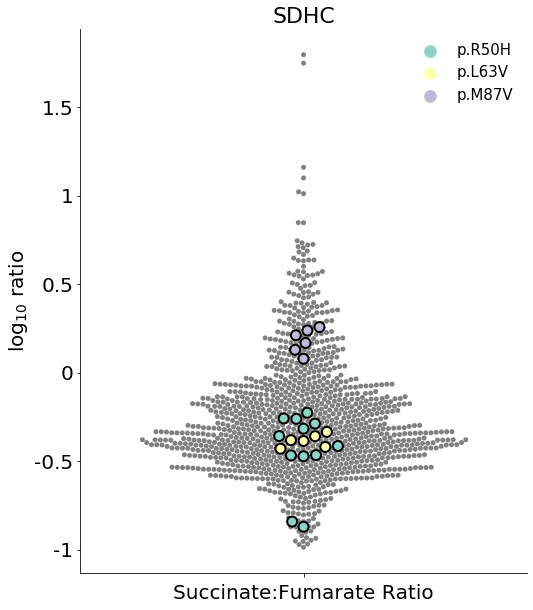

In [21]:
querygenesfratio("SDHC")

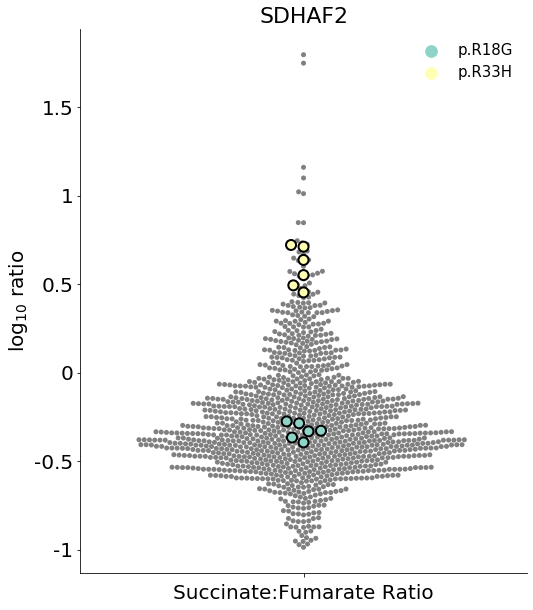

In [22]:
querygenesfratio("SDHAF2")

In [23]:
mutationonly = querygenesfratio.celllines_labeled[querygenesfratio.celllines_labeled["Mutation"] == 1]
nomutation = querygenesfratio.celllines_labeled[querygenesfratio.celllines_labeled["Mutation"] == 0]